# Geophysical Waveform Inversion

This notebook is intended to compete on "Yale/UNC-CH - Geophysical Waveform Inversion"  provided by Kaggle(https://www.kaggle.com/competitions/waveform-inversion/overview).  This repository provides a modular and optimized PyTorch pipeline for seismic velocity map prediction from seismic waveform data. It includes environment setup, data analysis, configuration file, dataset definition, model definition, training, evaluation, prediction, and rendering tools(streamlit-local app) using a custom application.

---

## 📁 Project Structure

├── Kaggle Environment # Go to Kaggle Settings menu and choose Accelerator GPU T4x2<br> 
├── pip install monai # MONAI (Medical Open Network for AI) is an open-source, PyTorch-based framework designed specifically for deep learning with imaging<br> 
├── Data Analysis # Deep Dive into the seismic data sets<br>
├── _cfg.py # configuration file for the model<br>
├── _dataset.py # Custom PyTorch Dataset for seismic data<br>
├── _models.py # model definition<br>
├── _utils.py # time format<br>
├── Train the model # with pre-trained model convnext_small<br>
├── Validation # Load the generated mode and check validation MAE<br>
├── Generate CSV for Kaggle competion # Prediction and rendering script<br>
├── Local App # streamlit<br>
├── README # This file<br>


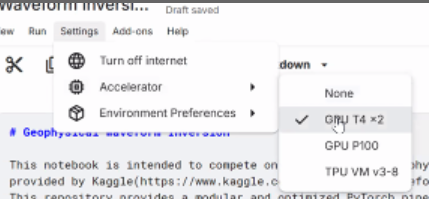

In [ ]:
pip install monai

### Checking GPU Requirements

In [ ]:
import torch
import monai
RUN_TRAIN = False # bfloat16 or float32 recommended
RUN_VALID = True
RUN_TEST  = True

if not torch.cuda.is_available() or torch.cuda.device_count() < 2:
    raise RuntimeError("Requires >= 2 GPUs with CUDA enabled.")



### Data Analysis


Deep dive into the dataset and visualize all the findings.


In [ ]:
#Data Analysis

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import os
import torch
import uuid
# ---------------------
# Device Setup
# ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

output_dir = "/kaggle/working/"


# Plot the velocity map
def plot_velocity(velocity, sample):
    fig, ax = plt.subplots(1, 1, figsize=(11, 5))
    img = ax.imshow(velocity[sample, 0, :, :], cmap='jet')
    ax.set_xticks(range(0, 70, 10))
    ax.set_xticklabels(range(0, 700, 100))
    ax.set_yticks(range(0, 70, 10))
    ax.set_yticklabels(range(0, 700, 100))
    ax.set_ylabel('Depth (m)', fontsize=12)
    ax.set_xlabel('Offset (m)', fontsize=12)
    clb = plt.colorbar(img, ax=ax)
    clb.ax.set_title('km/s', fontsize=8)
    plt.savefig(os.path.join(output_dir, f"velocity_map_sample_{sample}.png"))
    plt.close()
    plt.figure(figsize=(8, 2.5))
    plt.plot(np.arange(5, 700, 10), np.mean(velocity[sample, 0, :, :], axis=1))
    plt.xlabel("Depth (m)")
    plt.ylabel("Ave Velocity (m/s)")
    plt.savefig(os.path.join(output_dir, f"velocity_profile_sample_{sample}.png"))
    plt.close()

# Get information from the velocity map
def info_velocity(velocity, sample, for_show=True):
    ave_vel = np.mean(velocity[sample, 0, :, :])
    min_vel = np.min(velocity[sample, 0, :, :])
    max_vel = np.max(velocity[sample, 0, :, :])
    medi_vel = np.median(velocity[sample, 0, :, :])
    num_vels = len(np.unique(velocity[sample, 0, :, :]))
    y0_velL = np.mean(velocity[sample, 0, 0, 0:35])
    y0_velR = np.mean(velocity[sample, 0, 0, 35:])
    y09L_medi = np.median(velocity[sample, 0, 0:10, 0:35])
    y09R_medi = np.median(velocity[sample, 0, 0:10, 35:])
    y1029_medi = np.median(velocity[sample, 0, 10:30, :])
    y3049_medi = np.median(velocity[sample, 0, 30:50, :])
    y5069_medi = np.median(velocity[sample, 0, 50:, :])
    y09L_mean = np.mean(velocity[sample, 0, 0:10, 0:35])
    y09R_mean = np.mean(velocity[sample, 0, 0:10, 35:])
    y1029_mean = np.mean(velocity[sample, 0, 10:30, :])
    y3049_mean = np.mean(velocity[sample, 0, 30:50, :])
    y5069_mean = np.mean(velocity[sample, 0, 50:, :])
    if for_show:
        print("Number of distinct velocities: {}".format(num_vels))
        print("Average velocity: {:.2f} m/s".format(ave_vel))
        print(" Median velocity: {:.2f} m/s".format(medi_vel),
              "Min, Max: {:.2f}, {:.2f}".format(min_vel, max_vel))
        print("Ave y=0 velocities L,R: {:.2f}, {:.2f}".format(y0_velL, y0_velR))
        print("Median velocities in rows:  {:.2f}(0-9:L), {:.2f}(0-9:R),".format(
            y09L_medi, y09R_medi),
            "{:.2f}(10-29), {:.2f}(30-49), {:.2f}(50-69)".format(
            y1029_medi, y3049_medi, y5069_medi))
        print("  Mean velocities in rows:  {:.2f}(0-9:L), {:.2f}(0-9:R),".format(
            y09L_mean, y09R_mean),
            "{:.2f}(10-29), {:.2f}(30-49), {:.2f}(50-69)".format(
            y1029_mean, y3049_mean, y5069_mean))
    else:
        return (num_vels, y0_velL, y0_velR, y09L_medi, y09R_medi,
                y1029_medi, y3049_medi, y5069_medi)

# Make a gray-scale image of the seismic data
def plot_data(data, sample=-1):
    fig, ax = plt.subplots(1, 5, figsize=(20, 7))
    if len(data.shape) == 3:
        thisdata = data[:, :, :]
    else:
        thisdata = data[sample, :, :, :]
    maxabs = []
    for srclocid, xloc in enumerate([0, 17, 34, 52, 69]):
        maxabs.append(np.max(np.abs(thisdata[srclocid, 180:, xloc])))
    vrange = np.max(maxabs) * 0.5
    for iax in range(5):
        ax[iax].imshow(thisdata[iax, :, :], extent=[0, 70, 1000, 0],
                       aspect='auto', cmap='gray', vmin=-vrange, vmax=vrange)
    for axis in ax:
        axis.set_xticks(range(0, 70, 10))
        axis.set_xticklabels(range(0, 700, 100))
        axis.set_yticks(range(0, 2000, 1000))
        axis.set_yticklabels(range(0, 2, 1))
        axis.set_ylabel('Time (s)', fontsize=12)
        axis.set_xlabel('Offset (m)', fontsize=12)
    plt.savefig(os.path.join(output_dir, f"seismic_data_sample_{sample}.png"))
    plt.close()

def time_max_peak(isrc, xloc, thisdata):
    ipeak = np.argmax(thisdata[isrc, :, xloc])
    peakvals = thisdata[isrc, ipeak-3:ipeak+4, xloc]
    timevals = np.linspace(ipeak-3, ipeak+3, num=7, endpoint=True)
    if len(peakvals) == len(timevals):
        fitcoefs = np.poly1d(np.polyfit(timevals, peakvals, 2)).coef
        return -0.5 * fitcoefs[1] / fitcoefs[0]
    else:
        print("mis-matched lengths:\n", timevals, "\n", peakvals)
        return ipeak

def info_data(data, sample=-1, for_show=True):
    if len(data.shape) == 3:
        thisdata = data[:, :, :]
    else:
        thisdata = data[sample, :, :, :]
    partdata = thisdata[:, 0:225, :]
    vsurfaceL = 4*5*10*1000 / (
        time_max_peak(0, 6, partdata) - time_max_peak(0, 1, partdata) +
        time_max_peak(1, 11, partdata) - time_max_peak(1, 16, partdata) +
        time_max_peak(1, 23, partdata) - time_max_peak(1, 18, partdata) +
        time_max_peak(2, 28, partdata) - time_max_peak(2, 33, partdata)
    )
    vsurfaceR = 4*5*10*1000 / (
        time_max_peak(2, 40, partdata) - time_max_peak(2, 35, partdata) +
        time_max_peak(3, 46, partdata) - time_max_peak(3, 51, partdata) +
        time_max_peak(3, 58, partdata) - time_max_peak(3, 53, partdata) +
        time_max_peak(4, 63, partdata) - time_max_peak(4, 68, partdata)
    )
    vsurface = (vsurfaceL + vsurfaceR) / 2
    if for_show:
        idists = np.arange(0, 70)
        dists = []
        times = []
        timeref = np.argmax(thisdata[2, :, 34])
        for idist in idists:
            dists.append(10 * idist)
            times.append(np.sign(idist-34) * (np.argmax(thisdata[2, :, idist]) - timeref) / 1000.0)
        times = -1.0 * (np.array(times) - times[0])
        plt.figure(figsize=(6, 3))
        plt.plot(dists, times, '.b', alpha=0.7)
        plt.plot([dists[0], dists[-1]], [times[0], times[-1]], c='orange', alpha=0.6)
        plt.ylabel("$-$ Time (s)")
        plt.xlabel("Surface Distance (m)")
        plt.title("Time vs Distance from Source 2")
        plt.savefig(os.path.join(output_dir, f"time_vs_distance_sample_{np.random.randint(100000)}.png"))
        plt.close()
        print("Surface velocities : {:.2f}-Left, {:.2f}-Average, {:.2f}-Right".format(
            vsurfaceL, vsurface, vsurfaceR))
    else:
        return vsurfaceL, vsurface, vsurfaceR

def sources_data(data, sample=-1, for_show=True):
    if len(data.shape) == 3:
        thisdata = data[:, :, :]
    else:
        thisdata = data[sample, :, :, :]
    maxamps = []
    minamps = []
    for srclocid, xloc in enumerate([0, 17, 34, 52, 69]):
        maxamps.append(np.max(thisdata[srclocid, 180:, xloc]))
        minamps.append(np.min(thisdata[srclocid, 180:, xloc]))
    max_amp = np.max(maxamps)
    min_amp = np.min(minamps)
    delta_amp = 0.05 * (max_amp - min_amp)
    plt.figure(figsize=(8, 5))
    for srclocid, xloc in enumerate([0, 17, 34, 52, 69]):
        timeseries = thisdata[srclocid, :, xloc]
        offset = delta_amp * (xloc - 34) / 35.0
        plt.plot(np.array(range(1000)), timeseries + offset, alpha=0.7)
    plt.plot([0, 1000], [0.0, 0.0], c='gray', alpha=0.5)
    plt.ylim(1.10 * min_amp - delta_amp, 1.10 * max_amp + delta_amp)
    plt.xlabel('Time (ms)')
    plt.ylabel("Amplitude     Traces are offset.")
    plt.title("Waveforms at the 5 source locations")
    # Save the plot to output_dir with a unique name
    unique_name = f"waveforms_{uuid.uuid4().hex[:8]}.png"
    plt.savefig(os.path.join(output_dir, unique_name))
    plt.close()

# Look into Train_sample folder and visualize the data

last_data_file = "None"

def get_train_sample(dfind, ftscale=True):
    global velocity, data, last_data_file
    #D:\Personal\Mamun\Training\AI ML Bootcamp\Python\Workspace\Yale Project\train_samples
    train_dir = "/kaggle/input/waveform-inversion/train_samples/"
    output_dir = "/kaggle/working/images/"
    veltype, ifile, isample = traindf.loc[dfind, ["veltype", "ifile", "isample"]]
    if ("Vel" in veltype) or ("Style" in veltype):
        data_file = train_dir + veltype + "/data/data" + str(ifile) + ".npy"
        model_file = train_dir + veltype + "/model/model" + str(ifile) + ".npy"
    else:
        fault_num = 2 * ifile + 4 * ("_B" in veltype)
        data_file = train_dir + veltype + "/seis" + str(fault_num) + "_1_0.npy"
        model_file = train_dir + veltype + "/vel" + str(fault_num) + "_1_0.npy"
    if data_file != last_data_file:
        data = np.load(data_file)
        if ftscale:
            for itime in range(1000):
                data[:, :, itime, :] = (1.0 + (itime / 200) ** 1.5) * data[:, :, itime, :]
        velocity = np.load(model_file)
        last_data_file = data_file
    return velocity, data, isample

# Make a dataframe with 10,000 rows labeled by:
#   type - 5 x 2 string values
#   ifile - two numeric values: 0,1 or 1,2 or 2,4 or 6,8 depending on type
#   isample - 0 to 499
veltypes = ["FlatVel","FlatFault", "CurveVel", "CurveFault", "Style"]
veltype = []; ifile = []; isample = []
for this_type in veltypes:
    for this_AB in ["_A","_B"]:
        for this_ifile in [1,2]:
            for this_isample in range(500):  # **************************************
                veltype.append(this_type+this_AB); ifile.append(this_ifile); isample.append(this_isample)
# Make a dataframe from these
traindf = pd.DataFrame({"veltype":veltype, "ifile":ifile, "isample":isample})
# Select a dataframe index to look at
dfind = int(0.87*len(traindf))


print(list(traindf.loc[dfind,["veltype","ifile","isample"]]))
velocity, data, isample = get_train_sample(dfind)

print('Velocity map size:', velocity.shape)
print('Seismic data size:', data.shape)

# Look at the velocity map for the training sample
# isample defined above
plot_velocity(velocity, isample)
info_velocity(velocity, isample)

# Look at the seismic data for the sample
# isample = same as for the velocity map above
plot_data(data, isample)
info_data(data, isample)
sources_data(data, isample)

# Investigate Test Data
# Look at one of them (they seem to be shuffled)
##testdata = np.load('/kaggle/input/waveform-inversion/test/000039dca2.npy')  # messy
##testdata = np.load('/kaggle/input/waveform-inversion/test/0001026c8a.npy')  # very simple
testdata = np.load('/kaggle/input/waveform-inversion/test/00015b24d5.npy')  # weird straight lines
##testdata = np.load('/kaggle/input/waveform-inversion/test/800222ab0d.npy')  # messy
##testdata = np.load('/kaggle/input/waveform-inversion/test/a00269f1eb.npy')  # messy
##testdata = np.load('/kaggle/input/waveform-inversion/test/c0021521e5.npy')  # simple-ish

# Scale the seismic data by ~ (1+(t/a)^b) to help equalize the amplitudes vs time.
# (This is similar to applying AGC for visualization, but is included in the analysis too.)
for itime in range(1000):
    testdata[ : , itime, : ] = (1.0+(itime/200)**1.5)*testdata[ : , itime, : ]

print('Test data size:', testdata.shape)

plot_data(testdata)
info_data(testdata)
sources_data(testdata)

# For each sample,
# add y_ targets: y0_velL, y0_velR, y09L_medi, y09R_medi, y1039_medi, y4069_medi
nunique = []; y0_aves = []; y0_diffs = []
y09L_medis = []; y09R_medis = []; y1029_medis = []; y3049_medis = []; y5069_medis = []
# add x_ features: surface velocity average and R-L difference
surf_aves = []; surf_diffs = []
for dfind in traindf.index:
    velocity, data, isample = get_train_sample(dfind, ftscale=False)
    # velocity, target, values
    (num_vels, y0_velL, y0_velR, y09L_medi, y09R_medi,
         y1029_medi, y3049_medi, y5069_medi) = info_velocity(
                                            velocity, isample, for_show=False)
    nunique.append(num_vels)
    y0_aves.append((y0_velL + y0_velR)/2); y0_diffs.append(y0_velR - y0_velL)
    y09L_medis.append(y09L_medi); y09R_medis.append(y09R_medi); y1029_medis.append(y1029_medi)
    y3049_medis.append(y3049_medi); y5069_medis.append(y5069_medi)
    # seismic, feature, values
    velL, velave, velR = info_data(data, isample, for_show=False)
    surf_aves.append(velave)
    surf_diffs.append(velR-velL)
traindf["y_numVels"] = nunique
traindf["y_y0Ave"] = y0_aves
traindf["y_y0Diff"] = y0_diffs
traindf["y_09LMedi"] = y09L_medis
traindf["y_09RMedi"] = y09R_medis
traindf["y_1029Medi"] = y1029_medis
traindf["y_3049Medi"] = y3049_medis
traindf["y_5069Medi"] = y5069_medis
traindf["x_surfAve"] = surf_aves
traindf["x_surfDiff"] = surf_diffs

# Add color-coding based on the surfDiff and surfAve values
# Red = R-L not zero; Blue = R-L near zero
traindf["diff_clr"] = 'red'
# Use measured R-L difference to set color
seldiff = traindf["x_surfAve"] > (1300.0 + 1200.0*np.log10(1+np.abs(traindf["x_surfDiff"])))
# Use known R-L difference from the target (can't do this for test)
##seldiff = (np.abs(traindf["y_y0Diff"]) < 0.1*diff_color_change)
traindf.loc[seldiff, "diff_clr"] = 'blue'

# Print the dataframe
print(traindf.head(10))

# Summary values for the columns
traindf_means = traindf.describe().loc["mean",]
traindf.describe()

# Save the Training Dataframe
traindf.to_csv("traindf.csv", header=True, index=False, float_format='%.2f')
# For plots
velocity_range = (1400,4600)
print("\nMedian Ave Surface Velocity: {:.2f}".format(np.median(traindf["x_surfAve"])))
print("Average Ave Surface Velocity: {:.2f}\n".format(np.mean(traindf["x_surfAve"])))

diffs = traindf["x_surfDiff"]

plt.figure(figsize=(8,4))
plt.hist(traindf["x_surfAve"],bins=100)
plt.title("Train: Histogram of the Average Surface Velocity")
plt.xlabel("Surface Velocity (m/s)")
plt.xlim(velocity_range)
plt.savefig(os.path.join(output_dir, f"train_hist_surface_velocity.png"))
plt.show()

plt.figure(figsize=(8,4))
plt.hist(np.sign(diffs)*np.log10(np.abs(diffs) + 1.0), log=True, bins=100)
plt.title("Train: Histogram of the R-L Velocity Difference")
plt.xlabel("Signed Log10[1+ R-L Surface Velocity Difference (m/s) ]")
plt.savefig(os.path.join(output_dir, f"train_hist_velocity_difference.png"))
plt.show()



plt.figure(figsize=(8,5))
plt.scatter( np.sign(diffs)*(np.log10(np.abs(diffs) + 1.0)), traindf["x_surfAve"],
                             color=traindf["diff_clr"], s=2, alpha=0.25)
lindiffs = np.linspace(-3.0,3.0,100)  # <-- This is log10(1+ abs(surfDiff) )
plt.plot(lindiffs, 1300.0 + 1200.0*np.abs(lindiffs),c='gray',alpha=0.5)
plt.ylabel("Average Surface Velocity (m/s)")
plt.xlabel("Signed Log10[1+ R-L Velocity Difference (m/s) ]")
plt.title("Train: Average Surface Velocity vs. R-L Velocity Difference")
plt.ylim(velocity_range)
plt.savefig(os.path.join(output_dir, f"train_scatter_velocity_vs_difference.png"))  
plt.show()

# Look into the y=0 Average and Difference

# Scatter plot of the y=0 row Average and y=0 R-L Difference velocities
if True:
    diffs = traindf["y_y0Diff"]

    plt.figure(figsize=(6,3))
    plt.scatter( np.sign(diffs)*(np.log10(np.abs(diffs) + 1.0)), traindf["y_y0Ave"]/1000,
                             color=traindf["diff_clr"], s=2, alpha=0.25)
    plt.ylabel("Ave y=0 Velocity (km/s)")
    plt.xlabel("Signed Log10[1+ y=0 R-L Velocity Diff (m/s) ]")
    plt.title("Train: y=0 Average Velocity vs. y=0 R-L Velocity Difference")
    #plt.savefig(os.path.join(output_dir, f"train_y0_scatter_velocity_vs_diff.png"))
    plt.ylim(1.4,4.6) # in km/s
    plt.savefig(os.path.join(output_dir, f"train_y0_scatter_velocity_vs_diff.png"))
    plt.show()

    # Histogra of the y=0 R-L Diff
    plt.figure(figsize=(6,3))
    plt.hist(np.sign(diffs)*np.log10(np.abs(diffs) + 1.0), log=True, bins=100)
    plt.title("Train: Histogram of the y=0 R-L Velocity Difference")
    plt.xlabel("Signed Log10[1+ R-L y=0 Velocity Difference (m/s) ]")
    plt.savefig(os.path.join(output_dir, f"train_hist_y0_difference.png"))  
    plt.show()

    # Scatter plot of the Seismic R-L Diff vs the y=0 R-L Diff
    diffs = traindf["x_surfDiff"]
    diffy0 = traindf["y_y0Diff"]

    plt.figure(figsize=(6,3))
    plt.scatter( np.sign(diffy0)*(np.log10(np.abs(diffy0) + 1.0)),
                    np.sign(diffs)*(np.log10(np.abs(diffs) + 1.0)),
                             color=traindf["diff_clr"], s=2, alpha=0.25)
    plt.xlabel("y=0  Log10[1+ R-L Velocity Diff (m/s) ]")
    plt.ylabel("Seismic  Log10[1+ R-L Velocity Diff (m/s) ]")
    plt.title("Train: Seismic R-L Difference vs the y=0 R-L Difference")
    plt.savefig(os.path.join(output_dir, f"train_y0_scatter_velocity_vs_diff.png"))
    plt.show()
# Find some with y=0 diff = 0 and yet seismic R-L is high
##traindf[(traindf["y_y0Diff"] == 0) & (traindf["x_surfDiff"] > 200)]

# Simple degree 1 polynomial fit 
model = np.poly1d(np.polyfit(np.array(traindf["y_y0Ave"]), 
                             np.array(traindf["x_surfAve"]), 1))
# for polynomial line visualization 
polyline = np.linspace(1400, 4500, 100)  

plt.figure(figsize=(4,4))
plt.scatter( traindf["y_y0Ave"], traindf["x_surfAve"],
                color=traindf["diff_clr"], s=2, alpha=0.25)
plt.plot(polyline, model(polyline), c='orange',alpha=0.6)
plt.xlabel("y=0 Average Velocity")
plt.ylabel("Seismic Average Surface Velocity (m/s)")
plt.title("Train: Seismic Surface Velocity vs. y=0 Velocity")
plt.xlim(velocity_range)
plt.ylim(velocity_range)
plt.savefig(os.path.join(output_dir, f"train_surf_vs_y0.png"))
plt.show()

print("   Fit coefs [slope, intercept]:", model.coef,"\n")

# Compare the velocities in row ranges vs the surface velocity and velocity difference.
# Create simple model fits for each region.

surfAves = traindf["x_surfAve"]
surfDiffs = traindf["x_surfDiff"]
log_surfDiffs = np.sign(surfDiffs)*(np.log10(np.abs(surfDiffs) + 1.0))

# Fit red, blue separately, limit the surfAve range used
selblue = (traindf["diff_clr"] == 'blue') & (traindf["x_surfAve"] < 4000)
selred = (traindf["diff_clr"] == 'red') & (traindf["x_surfAve"] < 4000)

# for polynomial line visualization 
polyline = np.linspace(1400, 4000, 100)

# Save the fit models
rows_models = []
for y_rows in ["09L", "09R", "1029", "3049", "5069"]:
    
    rows_values = traindf["y_"+y_rows+"Medi"]
    surf_values = surfAves.copy()
    vel_axis_label = "Ave Surface Velocity (m/s)"
    # Modify surf_values for the 09L,R data
    if "09L" in y_rows:
        surf_values = surf_values - 0.5*surfDiffs
        vel_axis_label = "L Surface Velocity (m/s)"
    if "09R" in y_rows:
        surf_values = surf_values + 0.5*surfDiffs
        vel_axis_label = "R Surface Velocity (m/s)"
   
    plt.figure(figsize=(7,4))
    plt.scatter(surf_values, rows_values, color=traindf["diff_clr"], s=2, alpha=0.25)

    degree = 3
    # Blue polynomial fit:
    if "09" in y_rows:
        # Use combined L and R data for the model, selblue:
        surf_RLvalues = np.concatenate( ( (surfAves - 0.5*surfDiffs)[selblue], 
                                            (surfAves + 0.5*surfDiffs)[selblue] ) )
        rows_RLvalues = np.concatenate( ( traindf.loc[selblue,"y_09LMedi"], 
                                            traindf.loc[selblue,"y_09RMedi"] ) )
        model = np.poly1d(np.polyfit(surf_RLvalues, 
                                        rows_RLvalues, degree))
    else:
        model = np.poly1d(np.polyfit(np.array(surf_values[selblue]), 
                             np.array(rows_values[selblue]), degree))
    
    rows_models.append(model)
    blue_resids = (-1.0*model(np.array(surf_values[selblue])) + 
                             np.array(rows_values[selblue]))
    print("  Blue Fit coefs:", model.coef)
    plt.plot(polyline, model(polyline), c='blue',alpha=0.6)
    #
    # Red polynomial fit:
    if "09" in y_rows:
        # Use combined L and R data for the model, selred:
        surf_RLvalues = np.concatenate( ( (surfAves - 0.5*surfDiffs)[selred], 
                                            (surfAves + 0.5*surfDiffs)[selred] ) )
        rows_RLvalues = np.concatenate( ( traindf.loc[selred,"y_09LMedi"], 
                                            traindf.loc[selred,"y_09RMedi"] ) )
        model = np.poly1d(np.polyfit(surf_RLvalues, 
                                        rows_RLvalues, degree))
    else:
        model = np.poly1d(np.polyfit(np.array(surf_values[selred]), 
                             np.array(rows_values[selred]), degree))
rows_models.append(model)
red_resids = (-1.0*model(np.array(surf_values[selred])) + 
                             np.array(rows_values[selred]))
print("  Red Fit coefs:", model.coef)
plt.plot(polyline, model(polyline), c='purple',alpha=0.6)

plt.xlabel(vel_axis_label)
plt.xlim(1400, 4100) # reduce because of fitting range
plt.ylabel("y_"+y_rows+" Median")
plt.ylim(velocity_range)
plt.title("Train: y_"+y_rows+" Median vs. Surface Velocity")
plt.savefig(os.path.join(output_dir, f"train_rows"+y_rows+"_vs_average.png"))
plt.show()


# Show the residuals vs surface difference for the 09L, 09R
if "09" in y_rows:
    plt.figure(figsize=(7,2))
    plt.scatter( log_surfDiffs[selblue], blue_resids,
                            color=traindf.loc[selblue,"diff_clr"], s=2, alpha=0.25)
    plt.scatter( log_surfDiffs[selred], red_resids,
                            color=traindf.loc[selred,"diff_clr"], s=2, alpha=0.25)
    plt.ylim(-1000,1000)
    plt.xlabel("Signed Log10[1+ R-L Velocity Diff (m/s) ]")
    plt.ylabel("y_"+y_rows+" Residuals")
    plt.title("Train: y_"+y_rows+" * Residuals * vs. Surface Difference")
    plt.savefig(os.path.join(output_dir, f"train_residuals"+y_rows+"_vs_difference.png"))
    plt.show()
    
    
# Show the median values vs surface difference
plt.figure(figsize=(7,2))
plt.scatter(log_surfDiffs, rows_values,
                            color=traindf["diff_clr"], s=2, alpha=0.25)
plt.xlabel("Signed Log10[1+ R-L Velocity Diff (m/s) ]")
plt.ylabel("y_"+y_rows+" Median")
plt.ylim(velocity_range)
plt.title("Train: y_"+y_rows+" Median vs. Surface Difference")
plt.savefig(os.path.join(output_dir, f"train_rows"+y_rows+"_vs_difference.png"))
plt.show()
print("\n")

polyline = np.linspace(1400, 4000, 100)  
plt.figure(figsize=(6,3))
num_models = len(rows_models) // 2
for imod in range(num_models):
    plt.plot(polyline, rows_models[2*imod](polyline), c='blue',alpha=0.6)
    plt.plot(polyline, rows_models[2*imod+1](polyline), c='red',alpha=0.6)
plt.xlabel("Average Surface Velocity (m/s)")
plt.ylabel("Median of Rows")
plt.title("Fits of Row-Ranges Medians vs. Surface Velocity")
plt.savefig(os.path.join(output_dir, f"Average Surface Velocity.png"))
plt.show()

# What/why are the blue lines in the 1029 and 3049 median vs surface velocity plots?
# Find the samples in these lines
trainblue = traindf[traindf["diff_clr"] == 'blue']

print("\n\n  Look for 'blue' samples that have Rows Medians equal to the y=0 Average.")
print("  - List the counts of Velocity-Map Types.")
print("  - Check the y0Diff values: they are all 0, so vmaps are R-L symmetric.\n\n")

for yrows in ["09L","09R","1029","3049","5069"]:
    plt.figure(figsize=(6,2))
    plt.hist(np.clip(trainblue["y_"+yrows+"Medi"] - trainblue["y_y0Ave"],-800,800),
             log=True, bins=160)
    plt.xlim(-500,500)
    plt.xlabel("Rows "+yrows+" Median  -  y=0 Average")
    plt.savefig(os.path.join(output_dir, f"train_hist_{yrows}_difference.png"))
    plt.show()

    matchdf = trainblue[np.abs(trainblue["y_"+yrows+"Medi"] - trainblue["y_y0Ave"]) < 0.0001]
    print(matchdf["veltype"].value_counts())
    print(matchdf["y_y0Diff"].value_counts())



### Configuration File

Defining environmental variables. 


In [ ]:
%%writefile _cfg.py

#Configuration file
from types import SimpleNamespace
import torch

cfg= SimpleNamespace()
cfg.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg.local_rank = 0
cfg.seed = 123
cfg.subsample = None

cfg.backbone = "convnext_small.fb_in22k_ft_in1k"
cfg.ema = True
cfg.ema_decay = 0.99

cfg.epochs = 1
cfg.batch_size = 16
cfg.batch_size_val = 16

cfg.early_stopping = {"patience": 3, "streak": 0}
cfg.logging_steps = 100


### Dataset

Almost the same as the starter notebook,reading the meta-datafile (fold.csv) file to process data. The input dataset changes to Egor's [openfwi_float16_1](https://www.kaggle.com/datasets/egortrushin/open-wfi-1) and [openfwi_float16_2](https://www.kaggle.com/datasets/egortrushin/open-wfi-2) datasets.

In [ ]:
%%writefile _dataset.py
# Dataset

import os
import glob

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        cfg,
        mode = "train", 
    ):
        self.cfg = cfg
        self.mode = mode
        
        self.data, self.labels, self.records = self.load_metadata()

    def load_metadata(self, ):

        # Select rows
        df= pd.read_csv("/kaggle/input/openfwi-preprocessed-72x72/folds.csv")
        if self.cfg.subsample is not None:
            df= df.groupby(["dataset", "fold"]).head(self.cfg.subsample)

        if self.mode == "train":
            df= df[df["fold"] != 0]
        else:
            df= df[df["fold"] == 0]

        
        data = []
        labels = []
        records = []
        mmap_mode = "r"

        for idx, row in tqdm(df.iterrows(), total=len(df), disable=self.cfg.local_rank != 0):
            row= row.to_dict()

            # Hacky way to get exact file name
            p1 = os.path.join("/kaggle/input/open-wfi-1/openfwi_float16_1/", row["data_fpath"])
            p2 = os.path.join("/kaggle/input/open-wfi-1/openfwi_float16_1/", row["data_fpath"].split("/")[0], "*", row["data_fpath"].split("/")[-1])
            p3 = os.path.join("/kaggle/input/open-wfi-2/openfwi_float16_2/", row["data_fpath"])
            p4 = os.path.join("/kaggle/input/open-wfi-2/openfwi_float16_2/", row["data_fpath"].split("/")[0], "*", row["data_fpath"].split("/")[-1])
            farr= glob.glob(p1) + glob.glob(p2) + glob.glob(p3) + glob.glob(p4)
        
            # Map to lbl fpath
            farr= farr[0]
            flbl= farr.replace('seis', 'vel').replace('data', 'model')
            
            # Load
            arr= np.load(farr, mmap_mode=mmap_mode)
            lbl= np.load(flbl, mmap_mode=mmap_mode)

            # Append
            data.append(arr)
            labels.append(lbl)
            records.append(row["dataset"])

        return data, labels, records

    def __getitem__(self, idx):
        row_idx= idx // 500
        col_idx= idx % 500

        d= self.records[row_idx]
        x= self.data[row_idx][col_idx, ...]
        y= self.labels[row_idx][col_idx, ...]

        # Augs 
        if self.mode == "train":
            
            # Temporal flip
            if np.random.random() < 0.5:
                x= x[::-1, :, ::-1]
                y= y[..., ::-1]

        x= x.copy()
        y= y.copy()
        
        return x, y

    def __len__(self, ):
        return len(self.records) * 500

### _utils

Date and Time format

In [ ]:
%%writefile _utils.py

#Date and Time Format
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Model

The model uses the `ConvNeXt` backbone from timm. We modify the stem to aggressively downsample the height and we replace normalization layers with `InstanceNorm2d`.

## EMA + Ensemble
### ModelEMA
<li>Purpose: Maintains an Exponential Moving Average (EMA) of a model's weights during training.</li>

<li>Why: EMA often results in better generalization and smoother evaluation performance.</li>

<li>Key Functions:</li>
<ul>
<li>.update(model): Gradually updates the EMA weights based on the current model weights.</li>
<li>.set(model): Copies current model weights into the EMA model.</li>
</ul>

### EnsembleModel
<li>Purpose: Combines predictions from multiple models to improve robustness.</li>

<li>How: Averages the output of each model in the ensemble during forward pass.</li>

## Decoder Building Blocks
### ConvBnAct2d
<li>Purpose: Basic 2D convolution block with optional normalization and activation.</li>

<li>How: Applies Conv2D → Normalization (e.g., BatchNorm) → Activation (e.g., ReLU).</li>

### SCSEModule2d
<li>Purpose: Implements Spatial and Channel Squeeze-and-Excitation (SE) attention.</li>

<li>Why: Improves the model’s focus on important spatial and channel features.</li>

### Attention2d
<li>Purpose: Wrapper for attention mechanisms (currently supports SCSE).</li>

<li>How: Applies specified attention module or returns identity.</li>

### DecoderBlock2d
<li>Purpose: A single block of U-Net decoder.</li>

<li>Components:</li>

<ul>
<b>Upsampling (e.g., deconv or pixelshuffle)
<b>Skip connection processing
<b>Attention
<b>Dropout for regularization
</ul>

### UnetDecoder2d
<li>Purpose: Chains together multiple DecoderBlock2d instances to form a U-Net style decoder.</li>

<li>Configurable: Decoder depth, attention, normalization, upsampling mode, etc.</li>

### SegmentationHead2d
<li>Purpose: Final prediction head of the decoder.</li>

<li>How: A convolution followed by optional upsampling to return to original spatial resolution.</li>

## ConvNeXt-Based Encoder and Full Model
### _convnext_block_forward
<li>Purpose: Custom forward method for ConvNeXt blocks.</li>

<li>Why: Allows modifications like applying gamma scaling and residual connection tweaking.</li>

### Net
<li>Purpose: Full ConvNeXt-based U-Net model for 2D segmentation-like regression.</li>

<li>Encoder: Uses ConvNeXt (via timm) for feature extraction.</li>

<li>Decoder: U-Net decoder with attention, intermediate conv, and dropout.</li>

<li>Segmentation Head: Produces final 2D velocity map.</li>

<li>Special Features: </li>
<ul>
<li>proc_flip(): Flip-based test-time augmentation (TTA) to improve predictions.</li>

<li>replace_activations() and replace_norms(): Replaces all activation functions and normalization layers to improve convergence/generalization.</li>

<li>replace_forwards(): Swaps in custom forward functions for ConvNeXt blocks.</li>
</ul>


In [ ]:
%%writefile _model.py

# Model Definition
from copy import deepcopy
from types import MethodType

import torch
import torch.nn as nn
import torch.nn.functional as F

import timm
from timm.models.convnext import ConvNeXtBlock

from monai.networks.blocks import UpSample, SubpixelUpsample

####################
## EMA + Ensemble ##
####################

class ModelEMA(nn.Module):
    def __init__(self, model, decay=0.99, device=None):
        super().__init__()
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)


class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models).eval()

    def forward(self, x):
        output = None
        
        for m in self.models:
            logits= m(x)
            
            if output is None:
                output = logits
            else:
                output += logits
                
        output /= len(self.models)
        return output
        

#############
## Decoder ##
#############

class ConvBnAct2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding: int = 0,
        stride: int = 1,
        norm_layer: nn.Module = nn.Identity,
        act_layer: nn.Module = nn.ReLU,
    ):
        super().__init__()

        self.conv= nn.Conv2d(
            in_channels, 
            out_channels,
            kernel_size,
            stride=stride, 
            padding=padding, 
            bias=False,
        )
        self.norm = norm_layer(out_channels) if norm_layer != nn.Identity else nn.Identity()
        self.act= act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


class SCSEModule2d(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.Tanh(),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(
            nn.Conv2d(in_channels, 1, 1), 
            nn.Sigmoid(),
            )

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)

class Attention2d(nn.Module):
    def __init__(self, name, **params):
        super().__init__()
        if name is None:
            self.attention = nn.Identity(**params)
        elif name == "scse":
            self.attention = SCSEModule2d(**params)
        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)

class DecoderBlock2d(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        norm_layer: nn.Module = nn.Identity,
        attention_type: str = None,
        intermediate_conv: bool = False,
        upsample_mode: str = "deconv",
        scale_factor: int = 2,
    ):
        super().__init__()

        # Upsample block
        if upsample_mode == "pixelshuffle":
            self.upsample= SubpixelUpsample(
                spatial_dims= 2,
                in_channels= in_channels,
                scale_factor= scale_factor,
            )
        else:
            self.upsample = UpSample(
                spatial_dims= 2,
                in_channels= in_channels,
                out_channels= in_channels,
                scale_factor= scale_factor,
                mode= upsample_mode,
            )

        if intermediate_conv:
            k= 3
            c= skip_channels if skip_channels != 0 else in_channels
            self.intermediate_conv = nn.Sequential(
                ConvBnAct2d(c, c, k, k//2),
                ConvBnAct2d(c, c, k, k//2),
                )
        else:
            self.intermediate_conv= None

        self.attention1 = Attention2d(
            name= attention_type, 
            in_channels= in_channels + skip_channels,
            )

        self.conv1 = ConvBnAct2d(
            in_channels + skip_channels,
            out_channels,
            kernel_size= 3,
            padding= 1,
            norm_layer= norm_layer,
        )

        self.conv2 = ConvBnAct2d(
            out_channels,
            out_channels,
            kernel_size= 3,
            padding= 1,
            norm_layer= norm_layer,
        )
        self.attention2 = Attention2d(
            name= attention_type, 
            in_channels= out_channels,
            )
        self.dropout = nn.Dropout2d(p=0.2)  #improvement # 3


    def forward(self, x, skip=None):
        x = self.upsample(x)

        if self.intermediate_conv is not None:
            if skip is not None:
                skip = self.intermediate_conv(skip)
            else:
                x = self.intermediate_conv(x)

        if skip is not None:
            # print(x.shape, skip.shape)
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)   #Improvement # 3
        x = self.attention2(x)
        return x


class UnetDecoder2d(nn.Module):
    """
    Unet decoder.
    Source: https://arxiv.org/abs/1505.04597
    """
    def __init__(
        self,
        encoder_channels: tuple[int],
        skip_channels: tuple[int] = None,
        decoder_channels: tuple = (256, 128, 64, 32),
        scale_factors: tuple = (2,2,2,2),
        norm_layer: nn.Module = nn.Identity,
        attention_type: str = None,
        intermediate_conv: bool = False,
        upsample_mode: str = "deconv",
    ):
        super().__init__()
        
        if len(encoder_channels) == 4:
            decoder_channels= decoder_channels[1:]
        self.decoder_channels= decoder_channels
        
        if skip_channels is None:
            skip_channels= list(encoder_channels[1:]) + [0]

        # Build decoder blocks
        in_channels= [encoder_channels[0]] + list(decoder_channels[:-1])
        self.blocks = nn.ModuleList()

        for i, (ic, sc, dc) in enumerate(zip(in_channels, skip_channels, decoder_channels)):
            # print(i, ic, sc, dc)
            self.blocks.append(
                DecoderBlock2d(
                    ic, sc, dc, 
                    norm_layer= norm_layer,
                    attention_type= attention_type,
                    intermediate_conv= intermediate_conv,
                    upsample_mode= upsample_mode,
                    scale_factor= scale_factors[i],
                    )
            )

    def forward(self, feats: list[torch.Tensor]):
        res= [feats[0]]
        feats= feats[1:]

        # Decoder blocks
        for i, b in enumerate(self.blocks):
            skip= feats[i] if i < len(feats) else None
            res.append(
                b(res[-1], skip=skip),
                )
            
        return res

class SegmentationHead2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        scale_factor: tuple[int] = (2,2),
        kernel_size: int = 3,
        mode: str = "nontrainable",
    ):
        super().__init__()
        self.conv= nn.Conv2d(
            in_channels, out_channels, kernel_size= kernel_size,
            padding= kernel_size//2
        )
        self.upsample = UpSample(
            spatial_dims= 2,
            in_channels= out_channels,
            out_channels= out_channels,
            scale_factor= scale_factor,
            mode= mode,
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.upsample(x)
        return x
        

#############
## Encoder ##
#############

def _convnext_block_forward(self, x):
    shortcut = x
    x = self.conv_dw(x)

    if self.use_conv_mlp:
        x = self.norm(x)
        x = self.mlp(x)
    else:
        x = self.norm(x)
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
        x = self.mlp(x)
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous()

    if self.gamma is not None:
        x = x * self.gamma.reshape(1, -1, 1, 1)

    x = self.drop_path(x) + self.shortcut(shortcut)
    return x


class Net(nn.Module):
    def __init__(
        self,
        backbone: str,
        pretrained: bool = True,
    ):
        super().__init__()
        
        # Encoder
        self.backbone= timm.create_model(
            backbone,
            in_chans= 5,
            pretrained= pretrained,
            features_only= True,
            drop_path_rate=0.0,
            )
        ecs= [_["num_chs"] for _ in self.backbone.feature_info][::-1]

        # Decoder
        self.decoder= UnetDecoder2d(
            encoder_channels= ecs,
        )

        self.seg_head= SegmentationHead2d(
            in_channels= self.decoder.decoder_channels[-1],
            out_channels= 1,
            scale_factor= 1,
        )
        
        self._update_stem(backbone)
        
        self.replace_activations(self.backbone, log=True)
        self.replace_norms(self.backbone, log=True)
        self.replace_forwards(self.backbone, log=True)

    def _update_stem(self, backbone):
        if backbone.startswith("convnext"):

            # Update stride
            self.backbone.stem_0.stride = (4, 1)
            self.backbone.stem_0.padding = (0, 2)

            # Duplicate stem layer (to downsample height)
            with torch.no_grad():
                w = self.backbone.stem_0.weight
                new_conv= nn.Conv2d(w.shape[0], w.shape[0], kernel_size=(4, 4), stride=(4, 1), padding=(0, 1))
                new_conv.weight.copy_(w.repeat(1, (128//w.shape[1])+1, 1, 1)[:, :new_conv.weight.shape[1], :, :])
                new_conv.bias.copy_(self.backbone.stem_0.bias)

            self.backbone.stem_0= nn.Sequential(
                nn.ReflectionPad2d((1,1,80,80)),
                self.backbone.stem_0,
                new_conv,
            )

        else:
            raise ValueError("Custom striding not implemented.")
        pass

    def replace_activations(self, module, log=False):
        if log:
            print(f"Replacing all activations with GELU...")
        
        # Apply activations
        for name, child in module.named_children():
            if isinstance(child, (
                nn.ReLU, nn.LeakyReLU, nn.Mish, nn.Sigmoid, 
                nn.Tanh, nn.Softmax, nn.Hardtanh, nn.ELU, 
                nn.SELU, nn.PReLU, nn.CELU, nn.GELU, nn.SiLU,
            )):
                setattr(module, name, nn.GELU())
            else:
                self.replace_activations(child)

    def replace_norms(self, mod, log=False):
        if log:
            print(f"Replacing all norms with InstanceNorm...")
            
        for name, c in mod.named_children():

            # Get feature size
            n_feats= None
            if isinstance(c, (nn.BatchNorm2d, nn.InstanceNorm2d)):
                n_feats= c.num_features
            elif isinstance(c, (nn.GroupNorm,)):
                n_feats= c.num_channels
            elif isinstance(c, (nn.LayerNorm,)):
                n_feats= c.normalized_shape[0]

            if n_feats is not None:
                new = nn.InstanceNorm2d(
                    n_feats,
                    affine=True,
                    )
                setattr(mod, name, new)
            else:
                self.replace_norms(c)

    def replace_forwards(self, mod, log=False):
        if log:
            print(f"Replacing forward functions...")
            
        for name, c in mod.named_children():
            if isinstance(c, ConvNeXtBlock):
                c.forward = MethodType(_convnext_block_forward, c)
            else:
                self.replace_forwards(c)

        
    def proc_flip(self, x_in):
        x_in= torch.flip(x_in, dims=[-3, -1])
        x= self.backbone(x_in)
        x= x[::-1]

        # Decoder
        x= self.decoder(x)
        x_seg= self.seg_head(x[-1])
        x_seg= x_seg[..., 1:-1, 1:-1]
        x_seg= torch.flip(x_seg, dims=[-1])
        x_seg= x_seg * 1500 + 3000
        return x_seg

    def forward(self, batch):
        x= batch

        # Encoder
        x_in = x
        x= self.backbone(x)
        # print([_.shape for _ in x])
        x= x[::-1]

        # Decoder
        x= self.decoder(x)
        # print([_.shape for _ in x])
        x_seg= self.seg_head(x[-1])
        x_seg= x_seg[..., 1:-1, 1:-1]
        x_seg= x_seg * 1500 + 3000
    
        if self.training:
            return x_seg
        else:
            p1 = self.proc_flip(x_in)
            x_seg = torch.mean(torch.stack([x_seg, p1]), dim=0)
            return x_seg


## Future _model.py 
Following is to be tested in future to bring down the MAE by improving 6 items. Ran out of GPU time to test it properly

In [ ]:
#%%writefile _model.py
# modified model, uncomment the line above and generate the model and then train on sample data.
'''
1. Final Output: Apply tanh() + Output Scaling
2. Loss Function: Use Smooth L1 (Huber) Loss
3. Dropout in Decoder
4. Cosine Annealing Scheduler
5. (Optional) Use GroupNorm Instead of InstanceNorm
6. (Future) Add Vertical Flip in proc_flip()
'''

from copy import deepcopy
from types import MethodType

import torch
import torch.nn as nn
import torch.nn.functional as F

import timm
from timm.models.convnext import ConvNeXtBlock

from monai.networks.blocks import UpSample, SubpixelUpsample

####################
## EMA + Ensemble ##
####################

class ModelEMA(nn.Module):
    def __init__(self, model, decay=0.99, device=None):
        super().__init__()
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)


class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models).eval()

    def forward(self, x):
        output = None
        
        for m in self.models:
            logits= m(x)
            
            if output is None:
                output = logits
            else:
                output += logits
                
        output /= len(self.models)
        return output
        

#############
## Decoder ##
#############

class ConvBnAct2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding: int = 0,
        stride: int = 1,
        norm_layer: nn.Module = nn.Identity,
        act_layer: nn.Module = nn.ReLU,
    ):
        super().__init__()

        self.conv= nn.Conv2d(
            in_channels, 
            out_channels,
            kernel_size,
            stride=stride, 
            padding=padding, 
            bias=False,
        )
        self.norm = norm_layer(out_channels) if norm_layer != nn.Identity else nn.Identity()
        self.act= act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


class SCSEModule2d(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.Tanh(),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(
            nn.Conv2d(in_channels, 1, 1), 
            nn.Sigmoid(),
            )

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)

class Attention2d(nn.Module):
    def __init__(self, name, **params):
        super().__init__()
        if name is None:
            self.attention = nn.Identity(**params)
        elif name == "scse":
            self.attention = SCSEModule2d(**params)
        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)

class DecoderBlock2d(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        norm_layer: nn.Module = nn.Identity,
        attention_type: str = None,
        intermediate_conv: bool = False,
        upsample_mode: str = "deconv",
        scale_factor: int = 2,
    ):
        super().__init__()

        # Upsample block
        if upsample_mode == "pixelshuffle":
            self.upsample= SubpixelUpsample(
                spatial_dims= 2,
                in_channels= in_channels,
                scale_factor= scale_factor,
            )
        else:
            self.upsample = UpSample(
                spatial_dims= 2,
                in_channels= in_channels,
                out_channels= in_channels,
                scale_factor= scale_factor,
                mode= upsample_mode,
            )

        if intermediate_conv:
            k= 3
            c= skip_channels if skip_channels != 0 else in_channels
            self.intermediate_conv = nn.Sequential(
                ConvBnAct2d(c, c, k, k//2),
                ConvBnAct2d(c, c, k, k//2),
                )
        else:
            self.intermediate_conv= None

        self.attention1 = Attention2d(
            name= attention_type, 
            in_channels= in_channels + skip_channels,
            )

        self.conv1 = ConvBnAct2d(
            in_channels + skip_channels,
            out_channels,
            kernel_size= 3,
            padding= 1,
            norm_layer= norm_layer,
        )

        self.conv2 = ConvBnAct2d(
            out_channels,
            out_channels,
            kernel_size= 3,
            padding= 1,
            norm_layer= norm_layer,
        )
        self.attention2 = Attention2d(
            name= attention_type, 
            in_channels= out_channels,
            )

    def forward(self, x, skip=None):
        x = self.upsample(x)

        if self.intermediate_conv is not None:
            if skip is not None:
                skip = self.intermediate_conv(skip)
            else:
                x = self.intermediate_conv(x)

        if skip is not None:
            # print(x.shape, skip.shape)
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class UnetDecoder2d(nn.Module):
    """
    Unet decoder.
    Source: https://arxiv.org/abs/1505.04597
    """
    def __init__(
        self,
        encoder_channels: tuple[int],
        skip_channels: tuple[int] = None,
        decoder_channels: tuple = (256, 128, 64, 32),
        scale_factors: tuple = (2,2,2,2),
        norm_layer: nn.Module = nn.Identity,
        attention_type: str = None,
        intermediate_conv: bool = False,
        upsample_mode: str = "deconv",
    ):
        super().__init__()
        
        if len(encoder_channels) == 4:
            decoder_channels= decoder_channels[1:]
        self.decoder_channels= decoder_channels
        
        if skip_channels is None:
            skip_channels= list(encoder_channels[1:]) + [0]

        # Build decoder blocks
        in_channels= [encoder_channels[0]] + list(decoder_channels[:-1])
        self.blocks = nn.ModuleList()

        for i, (ic, sc, dc) in enumerate(zip(in_channels, skip_channels, decoder_channels)):
            # print(i, ic, sc, dc)
            self.blocks.append(
                DecoderBlock2d(
                    ic, sc, dc, 
                    norm_layer= norm_layer,
                    attention_type= attention_type,
                    intermediate_conv= intermediate_conv,
                    upsample_mode= upsample_mode,
                    scale_factor= scale_factors[i],
                    )
            )

    def forward(self, feats: list[torch.Tensor]):
        res= [feats[0]]
        feats= feats[1:]

        # Decoder blocks
        for i, b in enumerate(self.blocks):
            skip= feats[i] if i < len(feats) else None
            res.append(
                b(res[-1], skip=skip),
                )
            
        return res

class SegmentationHead2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        scale_factor: tuple[int] = (2,2),
        kernel_size: int = 3,
        mode: str = "nontrainable",
    ):
        super().__init__()
        self.conv= nn.Conv2d(
            in_channels, out_channels, kernel_size= kernel_size,
            padding= kernel_size//2
        )
        self.upsample = UpSample(
            spatial_dims= 2,
            in_channels= out_channels,
            out_channels= out_channels,
            scale_factor= scale_factor,
            mode= mode,
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.upsample(x)
        return x
        

#############
## Encoder ##
#############

def _convnext_block_forward(self, x):
    shortcut = x
    x = self.conv_dw(x)

    if self.use_conv_mlp:
        x = self.norm(x)
        x = self.mlp(x)
    else:
        x = self.norm(x)
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
        x = self.mlp(x)
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous()

    if self.gamma is not None:
        x = x * self.gamma.reshape(1, -1, 1, 1)

    x = self.drop_path(x) + self.shortcut(shortcut)
    return x


class Net(nn.Module):
    def __init__(
        self,
        backbone: str,
        pretrained: bool = True,
    ):
        super().__init__()
        
        # Encoder
        self.backbone= timm.create_model(
            backbone,
            in_chans= 5,
            pretrained= pretrained,
            features_only= True,
            drop_path_rate=0.0,
            )
        ecs= [_["num_chs"] for _ in self.backbone.feature_info][::-1]

        # Decoder
        self.decoder= UnetDecoder2d(
            encoder_channels= ecs,
        )

        self.seg_head= SegmentationHead2d(
            in_channels= self.decoder.decoder_channels[-1],
            out_channels= 1,
            scale_factor= 1,
        )
        
        self._update_stem(backbone)
        
        self.replace_activations(self.backbone, log=True)
        self.replace_norms(self.backbone, log=True)
        self.replace_forwards(self.backbone, log=True)

    def _update_stem(self, backbone):
        if backbone.startswith("convnext"):

            # Update stride
            self.backbone.stem_0.stride = (4, 1)
            self.backbone.stem_0.padding = (0, 2)

            # Duplicate stem layer (to downsample height)
            with torch.no_grad():
                w = self.backbone.stem_0.weight
                new_conv= nn.Conv2d(w.shape[0], w.shape[0], kernel_size=(4, 4), stride=(4, 1), padding=(0, 1))
                new_conv.weight.copy_(w.repeat(1, (128//w.shape[1])+1, 1, 1)[:, :new_conv.weight.shape[1], :, :])
                new_conv.bias.copy_(self.backbone.stem_0.bias)

            self.backbone.stem_0= nn.Sequential(
                nn.ReflectionPad2d((1,1,80,80)),
                self.backbone.stem_0,
                new_conv,
            )

        else:
            raise ValueError("Custom striding not implemented.")
        pass

    def replace_activations(self, module, log=False):
        if log:
            print(f"Replacing all activations with GELU...")
        
        # Apply activations
        for name, child in module.named_children():
            if isinstance(child, (
                nn.ReLU, nn.LeakyReLU, nn.Mish, nn.Sigmoid, 
                nn.Tanh, nn.Softmax, nn.Hardtanh, nn.ELU, 
                nn.SELU, nn.PReLU, nn.CELU, nn.GELU, nn.SiLU,
            )):
                setattr(module, name, nn.GELU())
            else:
                self.replace_activations(child)

    def replace_norms(self, mod, log=False):
        if log:
            print(f"Replacing all norms with InstanceNorm...")
            
        for name, c in mod.named_children():

            # Get feature size
            n_feats= None
            if isinstance(c, (nn.BatchNorm2d, nn.InstanceNorm2d)):
                n_feats= c.num_features
            elif isinstance(c, (nn.GroupNorm,)):
                n_feats= c.num_channels
            elif isinstance(c, (nn.LayerNorm,)):
                n_feats= c.normalized_shape[0]

            if n_feats is not None:
                new = nn.GroupNorm( #improvement 5: instead of InstanceNorm2d using GroupNorm
                    num_groups=8,
                    num_channels=n_feats,
                )                                
                # new = nn.InstanceNorm2d(
                #     n_feats,
                #     affine=True,
                #     )
                setattr(mod, name, new)
            else:
                self.replace_norms(c)

    def replace_forwards(self, mod, log=False):
        if log:
            print(f"Replacing forward functions...")
            
        for name, c in mod.named_children():
            if isinstance(c, ConvNeXtBlock):
                c.forward = MethodType(_convnext_block_forward, c)
            else:
                self.replace_forwards(c)

        
    def proc_flip(self, x_in):
        x_in= torch.flip(x_in, dims=[-3, -1])
        x= self.backbone(x_in)
        x= x[::-1]

        # Decoder
        x= self.decoder(x)
        x_seg= self.seg_head(x[-1])
        x_seg= x_seg[..., 1:-1, 1:-1]
        x_seg= torch.flip(x_seg, dims=[-1])
        x_seg= x_seg * 1500 + 3000
        return x_seg

    def forward(self, batch):
        x= batch

        # Encoder
        x_in = x
        x= self.backbone(x)
        # print([_.shape for _ in x])
        x= x[::-1]

        # Decoder
        x= self.decoder(x)
        # print([_.shape for _ in x])
        x_seg= self.seg_head(x[-1])
        x_seg = x_seg[..., 1:-1, 1:-1]    # following two lines- #1
        x_seg = torch.tanh(x_seg)         # Bound output to [-1, 1]
        x_seg = x_seg * 1500 + 3000       # Final range: [1500, 4500]

    
        if self.training:
            return x_seg
        else:
            p1 = self.proc_flip(x_in)
            x_seg = torch.mean(torch.stack([x_seg, p1]), dim=0)
            return x_seg


# Overview
This script trains a high-resolution ConvNeXt U-Net-based segmentation model for predicting seismic velocity maps. It supports distributed multi-GPU training, Exponential Moving Average (EMA) tracking, Cosine Annealing LR scheduler, and early stopping.

## Key Components
<ul>
1. Reproducibility & Setup
set_seed(): Fixes randomness for reproducible results.

setup() & cleanup(): Initialize and clean up PyTorch’s distributed training environment.

2. Data Loading
Uses a custom CustomDataset to load seismic waveform and velocity data.

Utilizes DistributedSampler to ensure each GPU gets unique batches.

3. Model Initialization
Loads multiple pre-trained ConvNeXt U-Net models from .pth files.

Wraps them into an EnsembleModel to improve generalization.

Supports EMA via ModelEMA to smooth weight updates and stabilize evaluation.

4. Training Loop
Trains the model with mixed precision (AMP) for speed/memory efficiency.

Uses SmoothL1Loss (Huber loss) for regression with robustness to outliers.

Optimizes with Adam and Cosine Annealing LR Scheduler for gradual learning rate decay.

Applies gradient clipping to prevent exploding gradients.

5. Validation
Performs distributed validation every epoch.

Supports EMA inference for better predictions.

Aggregates validation loss across all GPUs.

6. Model Saving & Early Stopping
Saves the best model (best_model_{seed}.pt) based on validation MAE.

Stops training early if the validation loss doesn't improve for patience epochs.
</ul>

In [ ]:
#Train the model

import os
import time 
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.amp import autocast, GradScaler

import torch.distributed as dist
from torch.utils.data import DistributedSampler
from torch.nn.parallel import DistributedDataParallel

from _cfg import cfg
from _dataset import CustomDataset
from _model import ModelEMA, Net, EnsembleModel
from _utils import format_time
import glob

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def setup(rank, world_size):
    if not dist.is_initialized():
        os.environ.setdefault("MASTER_ADDR", "localhost")
        os.environ.setdefault("MASTER_PORT", "12355")
        dist.init_process_group("nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)

def cleanup():
    dist.barrier()
    dist.destroy_process_group()
    return

def main(cfg):

    # ========== Datasets / Dataloaders ==========
    if cfg.local_rank == 0:
        print("="*25)
        print("Loading data..")
    train_ds = CustomDataset(cfg=cfg, mode="train")
    sampler= DistributedSampler(
        train_ds, 
        num_replicas=cfg.world_size, 
        rank=cfg.local_rank,
    )
    train_dl = torch.utils.data.DataLoader(
        train_ds, 
        sampler= sampler,
        batch_size= cfg.batch_size, 
        num_workers= 4,
    )
    
    valid_ds = CustomDataset(cfg=cfg, mode="valid")
    sampler= DistributedSampler(
        valid_ds, 
        num_replicas=cfg.world_size, 
        rank=cfg.local_rank,
    )
    valid_dl = torch.utils.data.DataLoader(
        valid_ds, 
        sampler= sampler,
        batch_size= cfg.batch_size_val, 
        num_workers= 4,
    )

    # ========== Model / Optim ==========
    # Load pretrained models
    models = []
    for f in sorted(glob.glob("/kaggle/input/simple-further-finetuned-bartley-open-models/*.pth")):
        print("Loading: ", f)
        m = Net(
            backbone="convnext_small.fb_in22k_ft_in1k",
            pretrained=False,
        )
        state_dict= torch.load(f, map_location=cfg.device, weights_only=True)
        state_dict= {k.removeprefix("_orig_mod."):v for k,v in state_dict.items()} # Remove torch.compile() prefix

        m.load_state_dict(state_dict)
        models.append(m)    
      # Combine
    model = EnsembleModel(models)
    model= model.to(cfg.local_rank)
    if cfg.ema:
        if cfg.local_rank == 0:
            print("Initializing EMA model..")
        ema_model = ModelEMA(
            model, 
            decay=cfg.ema_decay, 
            device=cfg.local_rank,
        )
    else:
        ema_model = None
    model= DistributedDataParallel(
        model, 
        device_ids=[cfg.local_rank], 
        )
    
    #criterion = nn.L1Loss()
    criterion = nn.SmoothL1Loss(beta=50.0) # improvement #2
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs) # Improvement # 4

    scaler = GradScaler()


    # ========== Training ==========
    if cfg.local_rank == 0:
        print("="*25)
        print("Are we ready to train {}, Mr. Mamun?".format(cfg.world_size))
        print("="*25)
    
    best_loss= 1_000_000
    val_loss= 1_000_000

    for epoch in range(0, cfg.epochs+1):
        if epoch != 0:
            tstart= time.time()
            train_dl.sampler.set_epoch(epoch)
    
            # Train loop
            print(f"Training Loop Epoch #:{epoch}")
            model.train()
            total_loss = []
            for i, (x, y) in enumerate(train_dl):
                x = x.to(cfg.local_rank)
                y = y.to(cfg.local_rank)
        
                with autocast(cfg.device.type):
                    logits = model(x)
                    
                loss = criterion(logits, y)
        
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
        
                torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
        
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
    
                total_loss.append(loss.item())
                
                if ema_model is not None:
                    ema_model.update(model)
                    
                if cfg.local_rank == 0 and (len(total_loss) >= cfg.logging_steps or i == 0):
                    train_loss = np.mean(total_loss)
                    total_loss = []
                    print("Epoch {}:     Train MAE: {:.2f}     Val MAE: {:.2f}     Time: {}     Step: {}/{}".format(
                        epoch, 
                        train_loss,
                        val_loss,
                        format_time(time.time() - tstart),
                        i+1, 
                        len(train_dl)+1, 
                    ))
    
        # ========== Valid ==========
        model.eval()
        val_logits = []
        val_targets = []
        with torch.no_grad():
            for x, y in tqdm(valid_dl, disable=cfg.local_rank != 0):
                x = x.to(cfg.local_rank)
                y = y.to(cfg.local_rank)
    
                with autocast(cfg.device.type):
                    if ema_model is not None:
                        out = ema_model.module(x)
                    else:
                        out = model(x)

                val_logits.append(out.cpu())
                val_targets.append(y.cpu())

            val_logits= torch.cat(val_logits, dim=0)
            val_targets= torch.cat(val_targets, dim=0)
                
            loss = criterion(val_logits, val_targets).item()

        # Gather loss
        v = torch.tensor([loss], device=cfg.local_rank)
        torch.distributed.all_reduce(v, op=dist.ReduceOp.SUM)
        val_loss = (v[0] / cfg.world_size).item()

        # Improvement # 4 Cosine Annealing Scheduler
        scheduler.step()

        # ========== Weights / Early stopping ==========
        stop_train = torch.tensor([0], device=cfg.local_rank)
        if cfg.local_rank == 0:
            es= cfg.early_stopping
            if val_loss < best_loss:
                print("New best: {:.2f} -> {:.2f}".format(best_loss, val_loss))
                print("Saved weights..")
                best_loss = val_loss
                if ema_model is not None:
                    torch.save(ema_model.module.state_dict(), f'best_model_{cfg.seed}.pt')
                else:
                    torch.save(model.state_dict(), f'best_model_{cfg.seed}.pt')
        
                es["streak"] = 0
            else:
                es= cfg.early_stopping
                es["streak"] += 1
                if es["streak"] > es["patience"]:
                    print("Ending training (early_stopping).")
                    stop_train = torch.tensor([1], device=cfg.local_rank)
        
        # Exits training on all ranks
        dist.broadcast(stop_train, src=0)
        if stop_train.item() == 1:
            return

    return
    


if __name__ == "__main__":

    # GPU Specs
    rank = int(os.environ.get("RANK", 0))  # Default rank 0
    world_size = int(os.environ.get("WORLD_SIZE", 1))  # Default world size 1
    _, total = torch.cuda.mem_get_info(device=rank)

    # Init
    setup(rank, world_size)
    time.sleep(rank)
    print(f"Rank: {rank}, World size: {world_size}, GPU memory: {total / 1024**3:.2f}GB", flush=True)
    time.sleep(world_size - rank)

    # Seed
    set_seed(cfg.seed+rank)

    # Run
    cfg.local_rank= rank
    cfg.world_size= world_size
    main(cfg)
    cleanup()


## Model validation and prediction 
This script validates a single submodel from a previously trained Ensemble ConvNeXt U-Net model using the validation dataset and reports the Mean Absolute Error (MAE).

### Key Steps
<ul>
1. Split Ensemble Checkpoint
Loads the ensemble model (best_model_123.pt).

Separates models.0 and models.1 into individual submodel checkpoints.

Saves them as best_model_123_submodel0.pt and best_model_123_submodel1.pt.

2. Load and Prepare Model
Initializes a fresh ConvNeXt U-Net model (convnext_small).

Loads weights from one submodel (submodel0.pt).

Moves the model to GPU/CPU as available and sets it to evaluation mode.

3. Validation DataLoader
Loads validation dataset via CustomDataset.

Uses a sequential sampler (not shuffled) for deterministic evaluation.

4. Validation Loop
Uses L1 Loss (MAE) to evaluate predictions.

Runs model inference using mixed precision (AMP) for efficiency.

Collects and concatenates predictions and targets for final MAE computation.

</ul>

### Output
Prints the final Validation MAE score at the end.

In [ ]:
# Load the new model and do the model validation
import torch
import torch.nn as nn
from _cfg import cfg
from _model import Net, ModelEMA, EnsembleModel
from _utils import format_time
from torch.utils.data import DataLoader
from torch import amp
from _dataset import CustomDataset

# Load ensemble state_dict
state_dict = torch.load("best_model_123.pt", map_location="cpu")

# Extract keys from 'models.0.' only
submodel_0_state_dict = {
    k.replace("models.0.", ""): v
    for k, v in state_dict.items()
    if k.startswith("models.0.")
}
# Save as a standalone checkpoint
torch.save(submodel_0_state_dict, "best_model_123_submodel0.pt")

submodel_1_state_dict = {
    k.replace("models.1.", ""): v
    for k, v in state_dict.items()
    if k.startswith("models.1.")
}
torch.save(submodel_1_state_dict, "best_model_123_submodel1.pt")

# Initialize the same architecture (use correct backbone!)
#model = Net(backbone='convnext_base', pretrained=False)
model = Net(backbone='convnext_small', pretrained=False)

# Load the submodel weights
model.load_state_dict(torch.load("best_model_123_submodel0.pt", map_location="cpu"), strict=True)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

valid_ds = CustomDataset(cfg=cfg, mode="valid")
valid_dl = torch.utils.data.DataLoader(
    valid_ds,
    sampler=torch.utils.data.SequentialSampler(valid_ds),
    batch_size=cfg.batch_size_val,
    num_workers=4, # this won't work at local machine 
)

criterion = nn.L1Loss()
val_logits = []
val_targets = []

with torch.no_grad():
    for x, y in tqdm(valid_dl):
        x = x.to(cfg.device)
        y = y.to(cfg.device)
        
        with amp.autocast(device_type=cfg.device.type, enabled=True):
            out = model(x)

        val_logits.append(out.cpu())
        val_targets.append(y.cpu())

val_logits = torch.cat(val_logits, dim=0)
val_targets = torch.cat(val_targets, dim=0)
total_loss = criterion(val_logits, val_targets).item()

print("=" * 25)
print("Val MAE: {:.2f}".format(total_loss))
print("=" * 25)

## Purpose
This script performs batch inference on .npy seismic waveform test files using a trained model, then formats and writes the predictions into a Kaggle-compatible submission CSV file.

### Key Steps
<ul>
1. Test Dataset Class
TestDataset loads .npy seismic waveform test files.

Extracts input tensors and corresponding file IDs (e.g., oid_x).

2. Test Setup
Loads the sample_submission.csv as a template.

Loads test files from the /kaggle/input/waveform-inversion/test/ directory.

Initializes a DataLoader with sequential sampling.

3. Prediction + CSV Writing
Iterates through the test DataLoader.

Performs inference using AMP (torch.amp.autocast) for speed and memory efficiency.

Extracts output predictions for each y-position.

Writes formatted results into submission.csv in the expected format:

Columns: oid_ypos, x_1, x_3, ..., x_69.

4. Performance Tracking
Measures and prints total inference time.
</ul>

#### Final Output
A submission.csv file with predicted seismic velocity maps, formatted for submission to the Kaggle competition.

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from tqdm import tqdm
import glob
import csv
import time
from torch.amp import autocast

# === Custom Dataset for Test ===
class TestDataset(Dataset):
    def __init__(self, test_files):
        self.test_files = test_files

    def __len__(self):
        return len(self.test_files)

    def __getitem__(self, i):
        test_file = self.test_files[i]
        test_stem = test_file.split("/")[-1].split(".")[0]
        x = np.load(test_file).astype(np.float32)
        x = torch.tensor(x)
        return x, test_stem

RUN_TEST = True
if RUN_TEST:

    submission_template = pd.read_csv("/kaggle/input/waveform-inversion/sample_submission.csv")

    test_files = sorted(glob.glob("/kaggle/input/waveform-inversion/test/*.npy"))
    test_ds = TestDataset(test_files)
    test_dl = DataLoader(
        test_ds,
        sampler=SequentialSampler(test_ds),
        batch_size=cfg.batch_size_val,
        num_workers=4,
    )

    x_cols = [f"x_{i}" for i in range(1, 70, 2)]
    fieldnames = ["oid_ypos"] + x_cols
    row_count = 0
    t0 = time.time()

    with open("submission.csv", "wt", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        with torch.no_grad():
            for inputs, oids in tqdm(test_dl):
                inputs = inputs.to(cfg.device)

                with autocast(device_type=cfg.device.type):  # 'cuda' or 'cpu'
                    # Predit with the model
                    outputs = model(inputs)

                outputs = outputs.cpu().numpy()  # shape: [B, 1, 70, 69]

                for batch_idx, oid in enumerate(oids):
                    y_pred = outputs[batch_idx, 0]  # shape [70, 69]

                    for y_pos in range(y_pred.shape[0]):
                        row = {f"x_{i}": float(y_pred[y_pos][i]) for i in range(1, 70, 2)}
                        row["oid_ypos"] = f"{oid}_y_{y_pos}"
                        writer.writerow(row)
                        row_count += 1

                        if row_count % 100000 == 0:
                            csvfile.flush()

    print("Saved predictions to submission.csv")
    print(f"Inference Time: {format_time(time.time() - t0)}")


# Web App to use the generated model to predict
This application is not supported at kaggle, and will be presented at our in class demo.

<ul>
Execute the app by running the following command in terminal from the directory where this script is located:      
<li>(1) cd code directory </li>
<li>(2) streamlit run seismicApp.py  </li>   
</ul>

In [ ]:
# WebApp - uses stremlit and publish locally.

import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from _model import Net  # Make sure _model.py is in the same directory
import os
import torch._classes  # Prevent Streamlit torch watcher crash
os.environ["STREAMLIT_WATCHER_TYPE"] = "none"

# Title
st.set_page_config(layout="wide")
st.title("Seismic Velocity Map Prediction App")

# Sidebar
st.sidebar.header("Upload Files")
uploaded_file = st.sidebar.file_uploader("Upload Seismic Waveform (.npy)", type=["npy"])
velocity_file = st.sidebar.file_uploader("(Optional) Upload Ground Truth Velocity Map (.npy)", type=["npy"])
model_type = st.sidebar.selectbox("Select Model", ["VelocityGAN", "InversionNet", "ConvNeXt U-Net"])

# Load ConvNeXt U-Net model
@st.cache_resource
def load_convnext_unet_model(path="best_model_1234_submodel0.pt"):
    model = Net(backbone='convnext_small', pretrained=False)
    state_dict = torch.load(path, map_location='cpu')
    model.load_state_dict(state_dict)
    model = model.eval().float()
    return model

# Dummy GAN/InversionNet loaders (replace with real)
def load_velocitygan_model():
    st.warning("VelocityGAN model loading not implemented.")
    return lambda x: x

def load_inversionnet_model():
    st.warning("InversionNet model loading not implemented.")
    return lambda x: x

# Inference with ConvNeXt
def predict_with_convnext(model, input_waveform):
    with torch.no_grad():
        x = torch.tensor(input_waveform).float()
        if x.dim() == 2:
            x = x.unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
        elif x.dim() == 3:
            x = x.unsqueeze(0)  # [1, C, H, W]
        output = model(x).squeeze().numpy()  # [H, W] or [5, H, W]
    return output

# Main Prediction
if st.button("Predict") and uploaded_file is not None:
    waveform = np.load(uploaded_file)

    if model_type == "ConvNeXt U-Net":
        model = load_convnext_unet_model()
        prediction = predict_with_convnext(model, waveform)
    elif model_type == "VelocityGAN":
        model = load_velocitygan_model()
        prediction = model(waveform)
    else:
        model = load_inversionnet_model()
        prediction = model(waveform)

    # Normalize prediction shape
    if prediction.ndim == 3:
        pred_img = prediction.mean(axis=0)  # (H, W)
    elif prediction.ndim == 2:
        pred_img = prediction
    else:
        raise ValueError(f"Unexpected prediction shape: {prediction.shape}")

    # Upsample to higher resolution for display
    pred_tensor = torch.tensor(pred_img).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
    pred_hr = F.interpolate(pred_tensor, scale_factor=2, mode='bilinear', align_corners=False)
    pred_img_highres = pred_hr.squeeze().numpy()  # [H*2, W*2]

    # Plot
    fig, axs = plt.subplots(1, 3 if velocity_file else 1, figsize=(18, 6))
    axs = axs if isinstance(axs, np.ndarray) else [axs]

    axs[0].imshow(pred_img_highres, cmap="jet", aspect="auto")
    axs[0].set_title("Predicted Velocity Map (Upscaled 2x)")

    if velocity_file:
        ground_truth = np.load(velocity_file)
        axs[1].imshow(ground_truth, cmap="jet", aspect="auto")
        axs[1].set_title("Ground Truth Velocity Map")

        # Resize ground truth if needed for shape match
        if ground_truth.shape != pred_img.shape:
            gt_tensor = torch.tensor(ground_truth).unsqueeze(0).unsqueeze(0).float()
            gt_resized = F.interpolate(gt_tensor, size=pred_img.shape, mode='bilinear', align_corners=False)
            ground_truth = gt_resized.squeeze().numpy()

        diff = np.abs(pred_img - ground_truth)
        axs[2].imshow(diff, cmap="hot", aspect="auto")
        axs[2].set_title("Prediction Error Map")

    print("Prediction shape:", prediction.shape)
    st.pyplot(fig)
    st.success("Prediction complete and displayed successfully!")



# execute the app by running the following command in terminal from the directory where this script is located:
#cd ConvNeXt-Final
# streamlit run seismicApp.py